### Import Packages

In [53]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn import model_selection, preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer
import sklearn.metrics as sklm

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
color = sns.color_palette()


from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from subprocess import check_output


%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

In [38]:
#Reduce VIF 

from statsmodels.stats.outliers_influence import variance_inflation_factor

class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=5.0, impute=True, impute_strategy='median'):
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.
        if impute:
            self.imputer = Imputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=5.0):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

### Import data

In [39]:

# change wd and import data files
os.chdir("/Users/hubertjenq/kaggle/sberbank russian housing")
train_df = pd.read_csv("train.csv",parse_dates=['timestamp'])
test_df = pd.read_csv("test.csv",parse_dates=['timestamp'])
VIFvalues=pd.read_csv("VIFvalues.csv")

#use only macroeconomic columns from the macro data
macroecon_cols = ["balance_trade", "balance_trade_growth", "eurrub", "average_provision_of_build_contract",
"micex_rgbi_tr", "micex_cbi_tr", "deposits_rate", "mortgage_value", "mortgage_rate",
"income_per_cap", "rent_price_4+room_bus", "museum_visitis_per_100_cap", "apartment_build"]



macro_df = pd.read_csv("macro.csv", parse_dates=['timestamp'], usecols=['timestamp'] + macroecon_cols)

## Data Quality/error fixes

### Fixes for training data

In [40]:
#drop the samples with price>100,000,000$

price_ulimit = 1E8
train_df.loc[train_df['price_doc'] < price_ulimit] 
train_df =  train_df.loc[train_df['price_doc'] < price_ulimit] 

#fix wrong state to the most occured state
train_df.loc[train_df['state'] == 33, 'state'] = train_df['state'].mode().iloc[0]

#fix build year errors
train_df[train_df['build_year']==0]['build_year']=np.nan
train_df[train_df['build_year']==1]['build_year']=np.nan
train_df[train_df['build_year']==3]['build_year']=np.nan
train_df[train_df['build_year']==4965]['build_year']=np.nan
train_df[train_df['build_year']==71]['build_year']=np.nan

In [41]:
train_df['build_year']=train_df['build_year'].replace(215,2015)
train_df['build_year']=train_df['build_year'].replace(20052009,2005)
train_df['build_year']=train_df['build_year'].replace(20,2000)

### resample the investment 

In [42]:

sub_df = train_df[train_df.timestamp < '2015-01-01']
sub_df = sub_df[sub_df.product_type.values == 'Investment']

ind_1m = sub_df[sub_df.price_doc <= 1000000].index
ind_2m = sub_df[sub_df.price_doc == 2000000].index
ind_3m = sub_df[sub_df.price_doc == 3000000].index

train_index = set(train_df.index.copy())

for ind, gap in zip([ind_1m, ind_2m, ind_3m], [10, 3, 2]):
    ind_set = set(ind)
    ind_set_cut = ind.difference(set(ind[::gap]))

    train_index = train_index.difference(ind_set_cut)

train_df = train_df.loc[train_index, :]


### Merge train/test for more cleaning/feature generation

In [43]:

#Make a data frame with all the data in it

#count test/train data
num_train=train_df.shape[0]
num_test=train_df.shape[0]

#save id and price of the train/test 
train_id=train_df['id']
train_logprice=np.log1p(train_df['price_doc'].values)
test_id=test_df['id']

#drop id and price
train_df.drop(['id','price_doc'],axis=1,inplace=True)
test_df.drop(['id'],axis=1,inplace=True)

#Combine test/train and the macro data by timestamp
all_df = pd.concat([train_df,test_df])
all_df = pd.merge_ordered(all_df,macro_df,on='timestamp',how='left')
all_df.head()


,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,c

### All data error fixes

In [44]:
#remove extreme life/full square footage values and set as NA

full_sq_ulimit = 250
life_sq_ulimit = 250
full_sq_llimit = 10
life_sq_llimit = 5
all_df.loc[all_df['full_sq']>full_sq_ulimit, 'full_sq'] = np.nan
all_df.loc[all_df['full_sq']<full_sq_llimit, 'full_sq'] = np.nan
all_df.loc[all_df['life_sq']>life_sq_ulimit, 'life_sq'] = np.nan
all_df.loc[all_df['life_sq']<life_sq_llimit, 'life_sq'] = np.nan

#living square footage is probably incorrect if it is over 90% of total square footage, so set to NA
all_df['life_full_ratio'] = all_df['life_sq'] / all_df['full_sq']
all_df.loc[all_df['life_full_ratio'] > 0.9, 'life_sq'] = np.nan

#Set max/floor floor values of 0 to nan
all_df.loc[all_df['floor'] == 0, 'floor'] = np.nan
all_df.loc[all_df['max_floor'] == 0, 'max_floor'] = np.nan

#Set the max/floor values to nan if the floor is higher than the "max floor"
all_df.loc[all_df['max_floor'] < all_df['floor'], ['floor', 'max_floor']] = np.nan
#remove buildings built in the future/very old buildings
all_df.loc[all_df['build_year'] > 2017, 'build_year'] = np.nan
all_df.loc[all_df['build_year'] < 1900, 'build_year'] = np.nan

#remove num room for extremes
all_df.loc[all_df['num_room'] == 0, 'num_room'] = np.nan
all_df.loc[all_df['num_room'] >= 10, 'num_room'] = np.nan

#set smaller than 3 kitchen_sq's to not footage
all_df.loc[all_df['kitch_sq'] <= 3.0 , 'kitch_sq'] = np.nan

#if the house is a high percentage kitchen, set the kitchen to na
all_df.loc[all_df['full_sq'] - all_df['kitch_sq'] <= 5.0 , 'kitch_sq'] = np.nan

#state typo
all_df.loc[all_df['state'] == 33 , 'state'] = 3

### Make new features

In [45]:
#Convert timestamp to year, month, day of week, and date 
all_df['yearsale']=pd.DatetimeIndex(all_df['timestamp']).year
all_df['monthsale']=pd.DatetimeIndex(all_df['timestamp']).month
all_df['dayofweeksale']=pd.DatetimeIndex(all_df['timestamp']).weekday
all_df['dateofsale']=pd.DatetimeIndex(all_df['timestamp']).day


In [46]:
#add houseage
all_df['houseage']=2020-all_df['build_year']

In [47]:
#add number of floors from top
all_df['floorsfromtop']=all_df['max_floor']-all_df['floor'].astype(float)
#relative floors
all_df['relativefloor']=all_df['floor']/all_df['max_floor'].astype(float)
#add average room size
all_df['avgroomsize']=all_df['full_sq']/all_df['num_room'].astype(float)
#add kitchen size percentage of house
all_df['kitchenpercentage']=all_df['kitch_sq']/all_df['full_sq'].astype(float)

#drop timestamp
all_df.drop(['timestamp'],inplace=True,axis=1)

#Drop high VIF
#drop covariates based on VIF:
highVIF = VIFvalues[VIFvalues.VIF>1000].covariate.values
all_df.drop(highVIF,inplace=True,axis=1)

In [48]:
all_obj_df=all_df.select_dtypes(include=['object']).copy()
all_num_df=all_df.select_dtypes(exclude=['object'])
#XforVIF=all_num_df.copy()[:num_train]

##CHANGE HERE
#all_num_df=ReducedX

#Change catagorical variables to factors

for o in all_obj_df:
    all_obj_df[o] = pd.factorize(all_obj_df[o])[0]

#put categorical and numeric variables back together
all_df_values=pd.concat([all_num_df,all_obj_df],axis=1)

#convert to numeric values
all_x = all_df_values.values

colnames=all_df_values.columns.values


In [49]:
#split all data back into test/training

train_x = all_x[:num_train]
test_x = all_x[num_train:]

#choose 7626 training and 30507 test
indices = np.random.permutation(train_x.shape[0])
valind = indices[:round(.2*train_x.shape[0])]
trainind = indices[round(.2*train_x.shape[0]):]

val_x = train_x[valind]
trainmod_x = train_x[trainind]
val_y = train_logprice[valind]
trainmod_y = train_logprice[trainind]



In [50]:
#Split imputed data
imputer=preprocessing.Imputer(missing_values='NaN',strategy='median',axis=0)
all_x_imputed=pd.DataFrame(imputer.fit_transform(all_x),columns=colnames)

train_x_imputed = all_x_imputed[:num_train]
test_x_imputed = all_x_imputed[num_train:]

val_x_imputed = train_x_imputed.iloc[valind]
trainmod_x_imputed = train_x_imputed.iloc[trainind]
val_y_imputed = train_logprice[valind]
trainmod_y_imputed = train_logprice[trainind]


In [55]:
RFmodel = RandomForestRegressor(n_estimators=200,oob_score=True)
RFmodel.fit(train_x_imputed, train_logprice)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [59]:
RFmodel.oob_score_

0.58728283316867236

In [17]:
y_log_pred_rf = RFmodel.predict(test_x_imputed)
y_pred_rf = np.exp(y_log_pred_rf) - 1

RFsub = pd.DataFrame({'id': test_id, 'price_doc': y_pred_rf})
RFsub.to_csv('RFsub.csv', index=False)

## XGBoost Model

In [18]:
#transformer = ReduceVIF()
# Only use 10 columns for speed in this example
#ReducedX = transformer.fit_transform(XforVIF[XforVIF.columns[:]], val_y)

#ReducedX.head()


#ReducedX.to_csv('VIFx.csv', index=False)

In [19]:
#Convert the data to xgb matrices

xgbfulltrain=xgb.DMatrix(train_x,train_logprice,feature_names=colnames)
xgbtrain=xgb.DMatrix(trainmod_x,trainmod_y,feature_names=colnames)
xgbval=xgb.DMatrix(val_x,val_y,feature_names=colnames)
xgbtest=xgb.DMatrix(test_x,feature_names=colnames)

### Find optimal number of boosting Rounds

In [20]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

partial_model = xgb.train(xgb_params, xgbtrain, num_boost_round=1000, evals=[(xgbval, 'eval')],early_stopping_rounds=20, verbose_eval=20)

num_boost_round = partial_model.best_iteration

[0]	eval-rmse:14.4317
Will train until eval-rmse hasn't improved in 20 rounds.
[20]	eval-rmse:5.18694
[40]	eval-rmse:1.88779
[60]	eval-rmse:0.743499
[80]	eval-rmse:0.402143
[100]	eval-rmse:0.330662
[120]	eval-rmse:0.318189
[140]	eval-rmse:0.315327
[160]	eval-rmse:0.314016
[180]	eval-rmse:0.312972
[200]	eval-rmse:0.312663
[220]	eval-rmse:0.312073
[240]	eval-rmse:0.311813
[260]	eval-rmse:0.311545
[280]	eval-rmse:0.311271
[300]	eval-rmse:0.311215
[320]	eval-rmse:0.310909
[340]	eval-rmse:0.310992
Stopping. Best iteration:
[320]	eval-rmse:0.310909



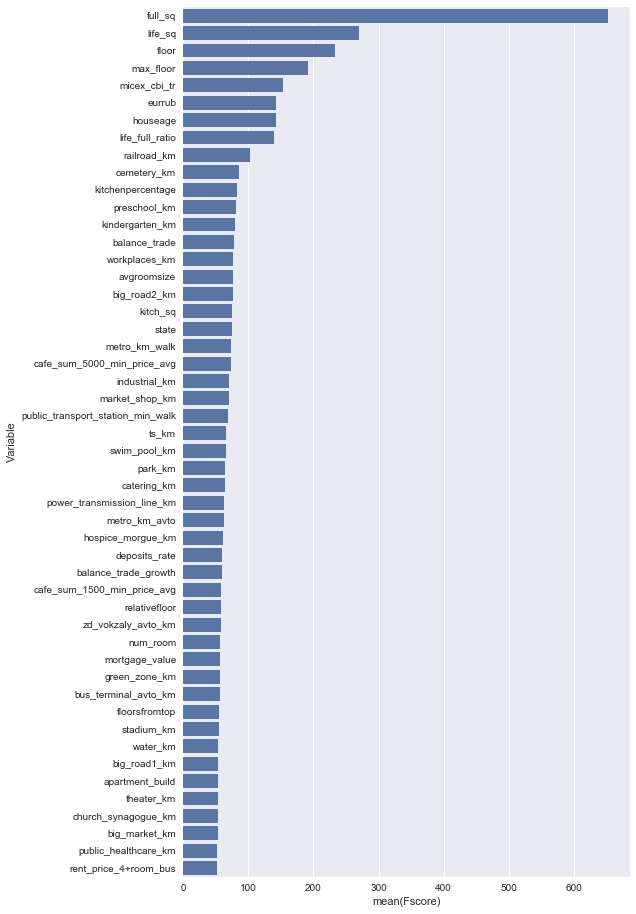

In [21]:
importance = partial_model.get_fscore()
VariableImpDf=pd.DataFrame(list(importance.items()),columns=['Variable','Fscore'])
SortedVIDf=VariableImpDf.sort_values('Fscore',ascending=False)
fig=plt.figure(figsize=(8,16))
sns.barplot(SortedVIDf.Fscore[0:50],SortedVIDf.Variable[0:50],color=color[0])

In [22]:
modelcv = xgb.cv(dict(xgb_params, silent=0), xgbfulltrain , nfold=5,num_boost_round=num_boost_round)
model = xgb.train(dict(xgb_params, silent=0), xgbfulltrain , num_boost_round=num_boost_round)

In [23]:
ylog_pred = model.predict(xgbtest)
y_pred = np.exp(ylog_pred) - 1

df_sub = pd.DataFrame({'id': test_id, 'price_doc': y_pred})

df_sub.to_csv('sub.csv', index=False)


### Hyperparameter optimization

In [24]:
    XGBspace = {
             'n_estimators' : hp.quniform('n_estimators', 200, 800,1),
             'max_depth': 5,
             'eta' : hp.uniform('eta', 0.001, 0.5),
             'min_child_weight' : hp.quniform('min_child_weight', 1, 7,1),
             'subsample' : hp.quniform('subsample', 0.5, 1,.05),
             'gamma' : hp.quniform('gamma', 0.05, 1,0.025),
             'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.025),
             'objective': 'reg:linear',
             'eval_metric': 'rmse',
             'silent' : 0,
             'lambda' : hp.quniform('lambda',0,1,.015),
             'alpha' : hp.quniform('alpha',0,1,.015)
             }



In [25]:
def XGBscore(params):
    boost_rounds=int(params['n_estimators'])
    model = xgb.train(params, xgbtrain, num_boost_round=boost_rounds)
    del params['n_estimators']
    
    predictions = model.predict(xgbval)
    yval=xgbval.get_label()
    score = np.sqrt(sklm.mean_squared_error(yval, predictions))
    print("\tObjective {0}\n\n".format(score))
    
    return {'loss': score, 'status': STATUS_OK}

In [26]:
trials = Trials()
best = fmin(fn=XGBscore, space=XGBspace, algo=tpe.suggest, trials=trials, max_evals=2000)

	Objective 0.3403776288032532


	Objective 0.3426452577114105


	Objective 0.314546674489975


	Objective 0.3431965112686157


	Objective 0.3449600338935852


	Objective 0.3115188479423523


	Objective 0.336381196975708


	Objective 0.3237270414829254


	Objective 0.32056963443756104


	Objective 0.3509244918823242


	Objective 0.34413209557533264


	Objective 0.31517601013183594


	Objective 0.31054675579071045


	Objective 0.33272701501846313


	Objective 0.33805137872695923


	Objective 0.3253263831138611


	Objective 0.33676284551620483


	Objective 0.33706408739089966


	Objective 0.32857537269592285


	Objective 0.3535272777080536


	Objective 1.168561577796936


	Objective 7.5961456298828125


	Objective 0.3118274509906769


	Objective 0.3130221962928772


	Objective 0.31166768074035645


	Objective 0.3511617183685303


	Objective 0.32196882367134094


	Objective 0.32169657945632935


	Objective 0.31942570209503174


	Objective 0.3140339255332947


	Objective 0.3137964606285095


	Objective 0.33144140243530273


	Objective 0.3169715702533722


	Objective 0.31200000643730164


	Objective 0.3094206750392914


	Objective 0.3092370927333832


	Objective 0.30902642011642456


	Objective 0.30950528383255005


	Objective 0.3125482201576233


	Objective 0.3114548921585083


	Objective 0.31116268038749695


	Objective 0.31153419613838196


	Objective 0.3125326335430145


	Objective 0.3088512420654297


	Objective 0.3087638318538666


	Objective 0.30994096398353577


	Objective 0.31283068656921387


	Objective 0.3147510290145874


	Objective 4.703543663024902


	Objective 0.31069350242614746


	Objective 0.3149183988571167


	Objective 0.3118463158607483


	Objective 0.31234821677207947


	Objective 0.3133663237094879


	Objective 0.31133052706718445


	Objective 0.3095436096191406


	Objective 0.31137534976005554


	Objective 0.3087799847126007


	Objective 3.2321979999542236


	Objective 0.3166804611682892


	Objective 0.30923113226890564


	Objective 0.313879489898681

	Objective 0.312195748090744


	Objective 0.3109649121761322


	Objective 0.30907630920410156


	Objective 0.31169870495796204


	Objective 0.309920996427536


	Objective 0.3112325668334961


	Objective 0.315664142370224


	Objective 0.315360963344574


	Objective 0.31054583191871643


	Objective 0.30873167514801025


	Objective 7.632991790771484


	Objective 0.31447675824165344


	Objective 0.3099452555179596


	Objective 0.3082645833492279


	Objective 0.30887529253959656


	Objective 0.3109504282474518


	Objective 0.3085967004299164


	Objective 0.31995490193367004


	Objective 5.331888198852539


	Objective 0.3094000220298767


	Objective 0.31055063009262085


	Objective 0.3286873698234558


	Objective 0.30988726019859314


	Objective 0.3092811703681946


	Objective 0.3360441029071808


	Objective 0.3145107924938202


	Objective 0.3258405923843384


	Objective 0.31042027473449707


	Objective 0.3082813024520874


	Objective 0.3126431405544281


	Objective 3.0284423828125


	Object

	Objective 0.3086254298686981


	Objective 0.31304922699928284


	Objective 0.32682546973228455


	Objective 0.3104024827480316


	Objective 0.313184529542923


	Objective 0.317870169878006


	Objective 0.30968770384788513


	Objective 7.408726215362549


	Objective 0.31423527002334595


	Objective 6.684260368347168


	Objective 0.3130161762237549


	Objective 0.31523942947387695


	Objective 0.30969133973121643


	Objective 0.31377092003822327


	Objective 0.3155739903450012


	Objective 0.31324267387390137


	Objective 0.3088536858558655


	Objective 0.30921435356140137


	Objective 0.3279557228088379


	Objective 0.31282666325569153


	Objective 0.3095918297767639


	Objective 0.3158104121685028


	Objective 0.31205183267593384


	Objective 0.308840811252594


	Objective 0.3098941445350647


	Objective 0.30865582823753357


	Objective 0.3097109794616699


	Objective 0.3090461492538452


	Objective 0.31096088886260986


	Objective 4.7662672996521


	Objective 0.3087450861930847


	Ob

	Objective 0.30934208631515503


	Objective 6.115896701812744


	Objective 0.3095766305923462


	Objective 0.3166942000389099


	Objective 0.3122994005680084


	Objective 0.312274307012558


	Objective 0.32519015669822693


	Objective 0.310041606426239


	Objective 0.3085205852985382


	Objective 0.30908578634262085


	Objective 0.30948907136917114


	Objective 0.30829524993896484


	Objective 0.308744341135025


	Objective 0.31083881855010986


	Objective 0.3143443465232849


	Objective 0.30916669964790344


	Objective 0.30922606587409973


	Objective 0.30847927927970886


	Objective 0.31093069911003113


	Objective 0.3092338442802429


	Objective 0.3093109130859375


	Objective 0.31067952513694763


	Objective 0.3099864721298218


	Objective 0.321186363697052


	Objective 0.3093729615211487


	Objective 0.3191355764865875


	Objective 6.169933795928955


	Objective 0.30877745151519775


	Objective 0.31065231561660767


	Objective 0.31119102239608765


	Objective 0.3102553188800812




	Objective 0.3169117867946625


	Objective 0.3155393898487091


	Objective 0.30880704522132874


	Objective 0.3126276135444641


	Objective 0.3107984960079193


	Objective 0.30942267179489136


	Objective 0.3103814721107483


	Objective 0.31186166405677795


	Objective 0.31209009885787964


	Objective 0.320845365524292


	Objective 0.30910417437553406


	Objective 0.31168121099472046


	Objective 0.3153845965862274


	Objective 0.34104976058006287


	Objective 0.309243381023407


	Objective 0.3122730553150177


	Objective 0.3141380846500397


	Objective 6.5983781814575195


	Objective 0.3101268410682678


	Objective 0.3201567828655243


	Objective 0.3306720554828644


	Objective 0.3104409873485565


	Objective 0.3191918730735779


	Objective 0.31106966733932495


	Objective 0.31245601177215576


	Objective 7.057259559631348


	Objective 0.3094158470630646


	Objective 0.30916839838027954


	Objective 0.30838683247566223


	Objective 0.31012699007987976


	Objective 0.309131383895874




KeyboardInterrupt: 

In [35]:
model = xgb.train(best, xgbfulltrain, num_boost_round=int(best['n_estimators']))
#np.sqrt(sklm.mean_squared_error(yval, model.predict(xgbval)))

NameError: name 'yval' is not defined

In [30]:
len(trials.results)

1497

In [ ]:
model.attributes()

In [ ]:
best={'alpha': 0.615,
   'colsample_bytree': 0.525,
   'eta': 0.012712929939504953,
   'gamma': 0.9750000000000001,
   'lambda': 0.6749999999999999,
   'min_child_weight': 7.0,
   'n_estimators': 979,
   'subsample': 0.8500000000000001}

In [ ]:
#values=[trials.results[x]['loss'] for x in range(0,len(trials.results))]

In [31]:
#if the optimization is cancelled before it finishes
values=[]
for x in range(0,(1496)):
    values.append(trials.results[x]['loss'])
trials.trials[values.index(min(values))]

{'book_time': datetime.datetime(2017, 6, 4, 14, 48, 31, 44000),
 'exp_key': None,
 'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'idxs': {'alpha': [1088],
   'colsample_bytree': [1088],
   'eta': [1088],
   'gamma': [1088],
   'lambda': [1088],
   'min_child_weight': [1088],
   'n_estimators': [1088],
   'subsample': [1088]},
  'tid': 1088,
  'vals': {'alpha': [0.8999999999999999],
   'colsample_bytree': [1.0],
   'eta': [0.02369485588839804],
   'gamma': [0.47500000000000003],
   'lambda': [0.78],
   'min_child_weight': [5.0],
   'n_estimators': [700.0],
   'subsample': [0.9]},
  'workdir': None},
 'owner': None,
 'refresh_time': datetime.datetime(2017, 6, 4, 14, 49, 5, 790000),
 'result': {'loss': 0.30767571926116943, 'status': 'ok'},
 'spec': None,
 'state': 2,
 'tid': 1088,
 'version': 0}

In [34]:
#Best parameter set:
best={'alpha': 0.8999999999999999,
   'colsample_bytree': 1.0,
   'eta': 0.02369485588839804,
   'gamma': 0.47500000000000003,
   'lambda': 0.78,
   'min_child_weight': 5.0,
   'n_estimators': 700.0,
   'subsample': 0.9}

In [36]:
ylog_pred = model.predict(xgbtest)
y_pred = np.exp(ylog_pred) - 1

df_sub = pd.DataFrame({'id': test_id, 'price_doc': y_pred})

df_sub.to_csv('sub.csv', index=False)
